## Review
### This recitation (11.08) covers two following lectures below:
- **10.30 (Wed)**
- **11.06 (Wed)**


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# import torchvision and matplotlib to download and visualize cifar10
import torchvision
from matplotlib.pyplot import imshow
import cv2
np.random.seed(231108)

### Image Features

<img src="https://drive.google.com/uc?export=view&id=1PJTmYQQpRi9g9niUm8BknHVx9GEDsXOr" alt="Drawing" height=500 />

In computer vision and image processing, *a **feature is a piece of information about the content** of an image*;  typically about whether a certain region of the image has certain properties.



*    **Features** may be specific structures in the image such as points, edges or objects.
*   **Features** may also be the result of a general neighborhood operation or feature detection applied to the image.


More broadly a feature is <u>any piece of information which is relevant for
solving the computational task related to a certain application.




Let’s look at the two main features we covered in class!

### Histogram of Oriented Gradients (HoG Feature)

<img src="https://drive.google.com/uc?export=view&id=1ccRgiWGOgjuHLNPvRWBzNVDi6dtNV4MV" alt="Drawing" height=300 />

**The histogram of oriented gradients (HOG)** is a feature descriptor used in computer vision and image processing for the purpose of object detection. The technique counts occurrences of gradient orientation in localized portions of an image.

### CNN Features


<img src="https://drive.google.com/uc?export=view&id=1Ny4M9PwnP0EJxhS6M6AYilgYCUtxHEUT" alt="Drawing" height=360 />


A **CNN feature**, in the context of Convolutional Neural Networks (CNNs), refers to a representation of a specific pattern or feature within an image. CNNs use layers of **convolutional operations** (what we are going to implement today) to detect various features like edges, textures, and more complex structures in images. These features are essential for tasks such as image recognition, object detection, and image classification.


### Various CNNs

<img src="https://drive.google.com/uc?export=view&id=1OzcLkg1NSgEYeb0DLOSNOSYXWsKrl6_-" alt="Drawing" height=450 />

There are a variety of CNN models available today, and you can use them as is or modify them to suit your task. It's all your choice!

Now, let's visualize CNN features just like we have seen in HoG features!

## Visualize Features

<img src="https://drive.google.com/uc?export=view&id=1_--V7VJMvHGjjQZ4tyUWYRPK4LhBhqgJ" alt="Drawing" height=300 />

The **CIFAR-10** dataset consists of 60000 32x32 color images in 10 classes, with 6000 images per class.

### Download a image from CIFAR-10


In [ ]:
# download cifar10
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified


image shape : (32, 32, 3)
This is an image of [dog].


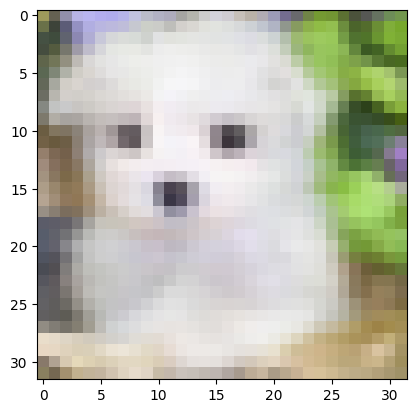

In [ ]:
# select random image among index 0-49999
# In this class, we will take a dog image

n = 40489

sample_img = np.asarray(dataset[n][0])

yi = dataset[n][1]
img_class = classes[dataset[n][1]]
imshow(np.asarray(sample_img))

print(f"image shape : {sample_img.shape}")
print(f'This is an image of [{img_class}].')

We are going to extract **features** from the sample image. First, let's start with image preprocessing.

### Preprocessing

**Min-max scaling:** This is a data preprocessing technique that transforms numerical data to a specific range, typically between 0 and 1, by rescaling values using a formula.

<img src="https://drive.google.com/uc?export=view&id=1JuC_Xcu7VzdrdkBlDgYmfmSuPVj6IUxJ" alt="Drawing" height=100 />


In [ ]:
# get the maximum and minimum pixel value from the image
max = np.max(sample_img)
min = np.min(sample_img)
print(f'We are going to preprocess our image using min:{min}-max:{max} scaling.')

# Apply the formula
sample_img = (sample_img - min) / (max - min)
max_ = np.max(sample_img)
min_ = np.min(sample_img)

# result
print(f'Scaled image: max={max_}, min={min_}')
sample_img = sample_img.transpose(2,0,1)[np.newaxis, :, :, :]
print(f'Preproccesed image shape {sample_img.shape}')

We are going to preprocess our image using min:19-max:249 scaling.
Scaled image: max=1.0, min=0.0
Preproccesed image shape (1, 3, 32, 32)


### Build Covolution Operations
Let's make two forward convolution operations using **img2col function**. (Review: 06_cnns_ind_0.ipynb)

In [ ]:
def im2col(input_data, filters, stride=1, pad=0):

    # init shape of image & filter
    N, C, H, W = input_data.shape
    f_N, _, f_H, f_W = filters.shape

    # output shape
    output_H = (H + 2 * pad - f_H) // stride + 1
    output_W = (W + 2 * pad - f_W) // stride + 1

    # add padding to height and width
    pad_data = np.pad(input_data, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant')

    # make output tensor
    output = np.zeros((N, C, f_H, f_W, output_H, output_W))

    for h in range(f_H):
        h_end = h + stride * output_H
        for w in range(f_W):
            w_end = w + stride * output_W
            output[:, :, h, w, :, :] = pad_data[:, :, h:h_end:stride, w:w_end:stride]

    output = output.transpose(0, 4, 5, 1, 2, 3).reshape(N * output_H * output_W, -1)

    return output

In [ ]:
# Note that the dim order is in (b,c,h,w)
print(sample_img.shape)

(1, 3, 32, 32)


### Build Random Gaussian Filters



*   First step contains **five filters** and  should have **kernel size of 3**.
*   Second step contains **ten filters** and  should have **kernel size of 3**.



In [ ]:
# Note that the dim order is in (out_f, in_f, f_h, f_w)
filters_1 = np.random.randn(5,3,3,3)
filters_2 = np.random.randn(10,5,3,3)

print('Filters:', filters_1.shape)
print('Filters:', filters_2.shape)

Filters: (5, 3, 3, 3)
Filters: (10, 5, 3, 3)


### Forward Convolution Operations

In [ ]:
# First Convolution Operation

stride = 2
pad = 2
X_col = im2col(sample_img, filters_1, stride=stride, pad=pad)
N, C, H, W = sample_img.shape
f_N, f_C, f_H, f_W = filters_1.shape
output_H = (H + 2 * pad - f_H) // stride + 1
output_W = (W + 2 * pad - f_W) // stride + 1
output = np.matmul(X_col, filters_1.reshape(f_N, -1).T)
output = output.reshape(N, output_H, output_W, f_N)
output = output.transpose(0, 3, 1, 2)

print('Output: ', output.shape)

Output:  (1, 5, 17, 17)


In [ ]:
# Second Convolution Operation

stride = 2
pad = 2
X_col = im2col(output, filters_2, stride=stride, pad=pad)
N, C, H, W = output.shape
f_N, f_C, f_H, f_W = filters_2.shape
output_H = (H + 2 * pad - f_H) // stride + 1
output_W = (W + 2 * pad - f_W) // stride + 1
final = np.matmul(X_col, filters_2.reshape(f_N, -1).T)
final = final.reshape(N, output_H, output_W, f_N)
final = final.transpose(0, 3, 1, 2)

print('Final: ', final.shape)

Final:  (1, 10, 10, 10)


#### Discussion

*   Why were the height and width of the image reduced so much?
*   Why did the number of image channels increase?


### Intercept Features

Let's intercept the two CNN feature we have calculated.

In [ ]:
feature_1 = output
feature_2 = final

# process to visualize the features
feature_1 = feature_1.squeeze(0)
feature_1 = feature_1.transpose(1,2,0)
feature_1 = np.sum(feature_1, axis=2)

feature_2 = feature_2.squeeze(0)
feature_2 = feature_2.transpose(1,2,0)
feature_2 = np.sum(feature_2, axis=2)

### Visualization of CNN
Let's now get a insight of the CNN feautures.

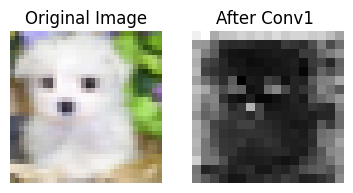

In [ ]:
fig = plt.figure(figsize=(9,9))

plt.subplot(141)
imshow(sample_img.squeeze(0).transpose(1,2,0))
plt.title('Original Image')
plt.axis('off')

plt.subplot(142)
imshow(feature_1, cmap='gray')
plt.title('After Conv1 ')
plt.axis('off')
plt.show()

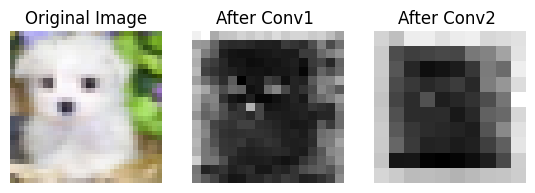

In [ ]:
fig = plt.figure(figsize=(9,9))

plt.subplot(141)
imshow(sample_img.squeeze(0).transpose(1,2,0))
plt.title('Original Image')
plt.axis('off')

plt.subplot(142)
imshow(feature_1, cmap='gray')
plt.title('After Conv1 ')
plt.axis('off')

plt.subplot(143)
imshow(feature_2, cmap='gray')
plt.title('After Conv2 ')
plt.axis('off')
plt.show()

#### Discussion


*  Can you see the difference in results depending on the depth of the CNN layers?
